In [26]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
import operator

# here's where we do ODEs
def single_pendulum():
    '''Simulates one pendulum'''
    # ------------define initial condition----------
    x0 = np.array([[.25],
                   [0]])
    t0 = 0
    
    # ----------------ODE---------------------------
    # set integration method
    r = ode(derivs_single_pendulum).set_integrator('dopri5')
    
    # set intitial value
    r.set_initial_value(x0, t0)
    
    # set intitial value
    r.set_initial_value(x0, t0)
    
    # define ending time and time increment
    t_end = 60  # s
    dt = .01 # s
    
    # run ODE
    t = []
    x = []
    while r.successful() and r.t < t_end:
        t.append(r.t+dt)
        x.append(r.integrate(r.t+dt))
        
    organized_data = organize_data_one_pendulum(x)

    # -----------------plot----------------------
    theta = organized_data[0]
    omega = organized_data[1]
    
    plt.plot(t, theta)
    plt.show()
    
    
def double_pendulum():
    '''Simulates two pendulum system'''
    # ------------define intial condition-----------
    # form of
        # theta1 rad
        # omega1 rad/s
        # theta2 rad
        # omega2 rad/s
        # Y m
        # V m/s
    x0 = np.array([[0],
                   [0.01],
                   [.05],
                   [.051],
                   [0],
                   [0]])
    t0 = 0
    
    # --------------------ODE--------------------
    # set integration method
    r = ode(derivs_angles).set_integrator('dopri5')
    
    # set intitial value
    r.set_initial_value(x0, t0)
    
    # define ending time and time increment
    t_end = 300 # s
    dt = .01 # s
    
    # run ODE
    t = []
    x = []
    while r.successful() and r.t < t_end:
        t.append(r.t+dt)
        x.append(r.integrate(r.t+dt))
    
    #print x
    organized_data = organize_data_two_pendulums(x)
    #print organized_data

    # -----------------plot----------------------
    theta_1 = organized_data[0]
    omega_1 = organized_data[1]
    theta_2 = organized_data[2]
    omega_2 = organized_data[3]
    Y = organized_data[4]
    V = organized_data[5]
    
    plt.plot(t, theta_1, 'r', t, theta_2, 'b')
    #plt.plot(t, Y)

    plt.show()
    
    
def organize_data_one_pendulum(data):
    '''organizes list of arrays into lists of values'''
    theta = []
    omega = []
    
    for data_point in data:
        theta.append(data_point[0])
        omega.append(data_point[1])
    
    return theta, omega

    
def organize_data_two_pendulums(data):
    '''organizes list of arrays into lists of values'''
    theta_1 = []
    omega_1 = []
    theta_2 = []
    omega_2 = []
    Y = []
    V = []
    for data_point in data:
        theta_1.append(data_point[0])
        omega_1.append(data_point[1])
        theta_2.append(data_point[2])
        omega_2.append(data_point[3])
        Y.append(data_point[4])
        V.append(data_point[5])
    
    return theta_1, omega_1, theta_2, omega_2, Y, V

def derivs_single_pendulum(t,x):
    '''definition of derivative for one clock'''
    #TODO: Figure out the definition of gamma
    gamma = .005
    
    A = np.array([[0,1],
                  [-1,-2*gamma]])
    
    dxdt = np.matmul(A,x)
    
    return dxdt

def derivs_angles(t,x):
    '''function to compute right hand side of 
    differential equation
    X is matrix with values: theta_1, omega_1, theta_2,
    omega_2, Y, V'''
    # TODO: add escapement force for pendulum 1
    # TODO: add escapement force for pendulum 2
    
    # define constants
    mass_pendulum_1 = .043 # kg
    mass_pendulum_2 = .043 # kg
    mass_cart = 3.45 # kg
    length_pendulum = .2 # m
    gravity = 9.8 # m/s^2
    spring_constant = 0 # N/m
    little_b = .005
    big_b = .005
    F_kick = 0.005
    
    mass_ratio = mass_cart + mass_pendulum_1 + mass_pendulum_2
    
    #mu = mass_pendulum/mass_ratio
#   mu = .005
    mu = math.sqrt(mass_pendulum_1*mass_pendulum_2)/mass_ratio
   # mu = (mass_pendulum_1+mass_pendulum_2)/mass_ratio
    little_gamma = (little_b*math.sqrt(length_pendulum/(4*gravity)))/mass_ratio
#   little_gamma = 0
    big_gamma = (big_b*math.sqrt(length_pendulum/(4*gravity)))/mass_ratio
    
    omega = spring_constant/mass_ratio
    
    # system of equations
    A = np.array([[1,0,0,0,0,0],
                  [0,1,0,0,0,1],
                  [0,0,1,0,0,0],
                  [0,0,0,1,0,1],
                  [0,0,0,0,1,0],
                  [0,mu,0,mu,0,1]])
    B = np.array([[0,1,0,0,0,0],
                  [-1,-2*little_gamma,0,0,0,0],
                  [0,0,0,1,0,0],
                  [0,0,-1,-2*little_gamma,0,0],
                  [0,0,0,0,0,1],
                  [0,0,0,0,-omega**2,-2*big_gamma]])
    
    F1 = force_escape(x[1], x[2])
    F2 = force_escape(x[3], x[4])
    
    F = [[0], [F1*F_kick], [0], [F2*F_kick], [0], [0]]
    
    # return derivatives
    right_side = np.matmul(B,x)
    dxdt = map(operator.add, np.matmul(right_side, A.transpose()), F)
#     dxdt = np.matmul(right_side, A.transpose())
    return dxdt

def derivs_paper(t,x):
    '''definition of derivative from the paper'''
    pass

def force_escape(theta, omega):
    '''computes force of escapement given
        x: x position
        v: computed velocity at that point'''
    
    theta1 = -0.025;        
    theta2 = 0.0;        
    F = 0;          # default is escapment has no force
    if (theta > theta1 and theta < theta2 and np.sign(omega)>0):  # if we are in range of the kick
        F = 1;              # kick in direction we are going   
    return F

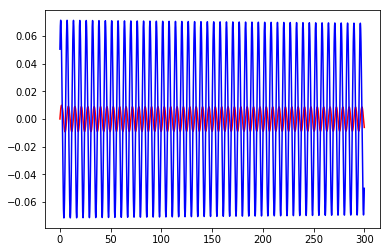

In [27]:
double_pendulum()

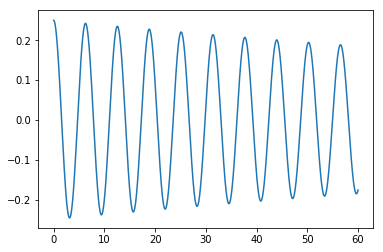

In [11]:
single_pendulum()

### Links
[scipy ODE](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html)

[Matlab to Python equivelants](https://docs.scipy.org/doc/numpy-dev/user/numpy-for-matlab-users.html)